In [1]:
import os 
# list(os.walk('./data'))
for i in os.walk('./data'):
    if len(i[-1]) != 0:
        for fname in i[-1]:
            print(os.path.join(i[0], fname))

./data/data283931/train.csv
./data/data283931/test.csv


<Axes: >

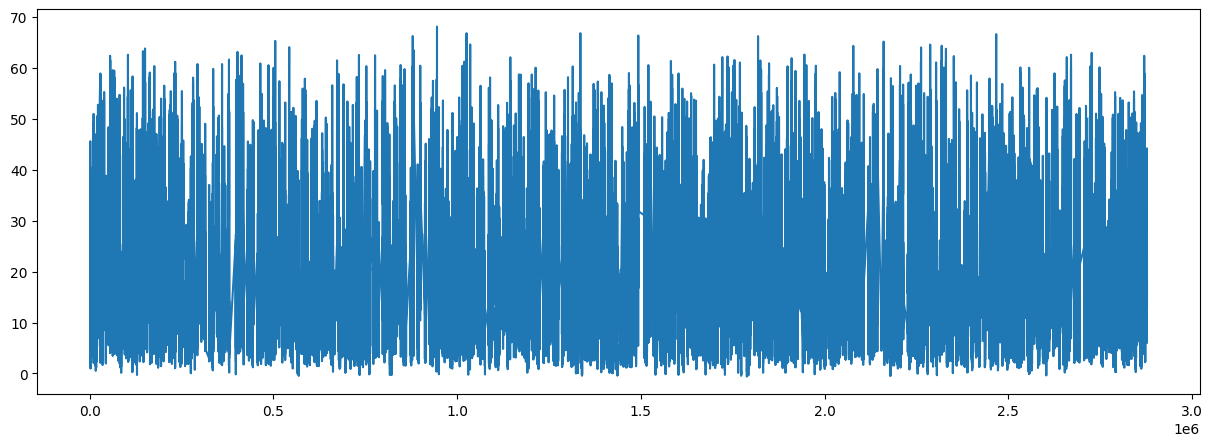

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

test = pd.read_csv('./data/data283931/test.csv', header=0)
train = pd.read_csv('./data/data283931/train.csv', header=0)
train[train['type'] == 5]['target'].plot(linestyle='-', figsize=(15, 5))

In [2]:
import os 
# list(os.walk('./data'))
for i in os.walk('./data'):
    if len(i[-1]) != 0:
        for fname in i[-1]:
            print(os.path.join(i[0], fname))

./data/data283931/test.csv
./data/data283931/train.csv


In [3]:
"""
    1. explore the data using pandas and numpy
    2. get the trend of the full data
    3. select the solutions
"""

import pandas as pd
import numpy as np
train_df = pd.read_csv('./data/data283931/train.csv', header=0)
test_df = pd.read_csv('./data/data283931/test.csv', header=0)

train_df.describe()

,dt,type,target
count,2.877305e+06,2.877305e+06,2.877305e+06
mean,2.576864e+02,3.232505e+00,3.221786e+01
std,1.429536e+02,2.832795e+00,5.035682e+01
min,1.100000e+01,0.000000e+00,-6.130000e-01
25%,1.340000e+02,1.000000e+00,1.331600e+01
50%,2.570000e+02,3.000000e+00,2.235000e+01
75%,3.810000e+02,5.000000e+00,3.443900e+01
max,5.060000e+02,1.800000e+01,1.191678e+03


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2877305 entries, 0 to 2877304
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   id      object 
 1   dt      int64  
 2   type    int64  
 3   target  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 87.8+ MB


<Axes: >

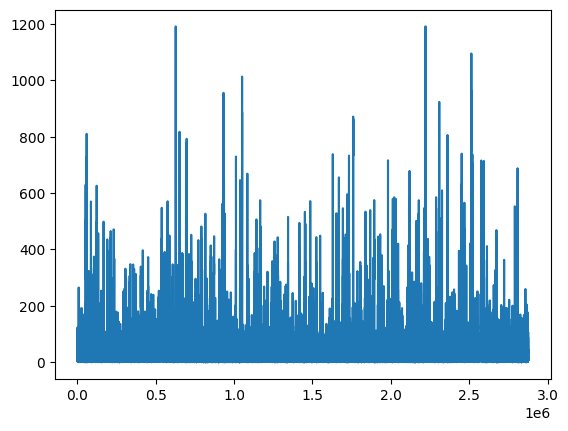

In [5]:
# get the series of the train target and see the trend
train_tseries = train_df.loc[:, 'target']
train_tseries.plot(kind='line')

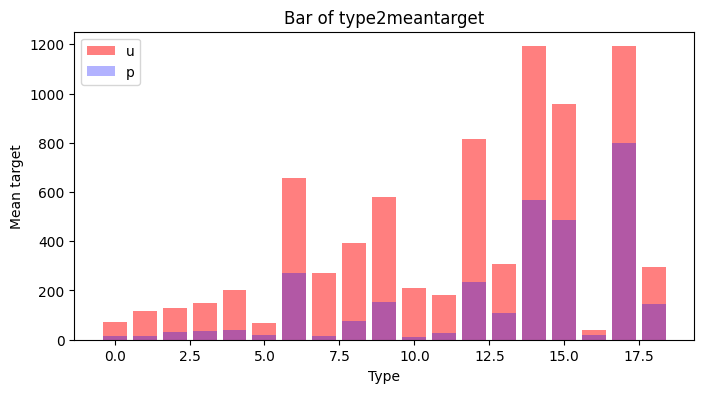

In [6]:
import matplotlib.pyplot as plt

# groupby type and mean target
tmp_mean = train_df.groupby('type')['target'].mean().reset_index()
tmp_max = train_df.groupby('type')['target'].max().reset_index()

# create figure and plot
fig = plt.figure(figsize=(8, 4))
plt.bar(tmp_max['type'], tmp_max['target'], label='mean_target', color='red', alpha=0.5)
plt.bar(tmp_mean['type'], tmp_mean['target'], label='mean_target', color='blue', alpha=0.3)
plt.xlabel('Type')
plt.ylabel('Mean target')
plt.legend('upper right')
plt.title('Bar of type2meantarget')
plt.show()

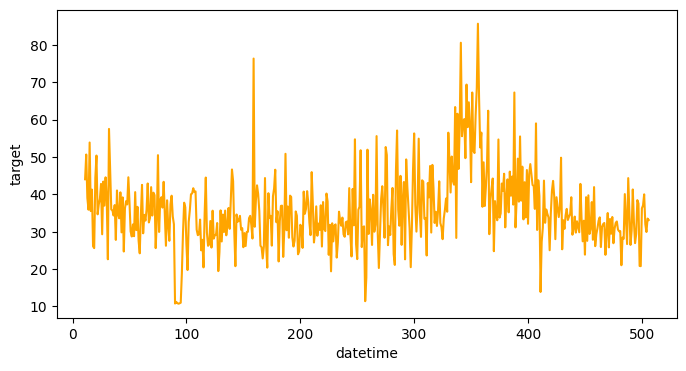

In [7]:
# explore the specific id
tmp_00037f39cf = train_df[train_df['id'] == '00037f39cf']
tmp_00037f39cf_sorted = tmp_00037f39cf.sort_values(by='dt', ascending=True)
tmp_00037f39cf_sorted = tmp_00037f39cf_sorted.reset_index(drop=True)
plt.figure(figsize=(8,4))
plt.plot(tmp_00037f39cf_sorted['dt'], tmp_00037f39cf_sorted['target'], color='orange')
plt.xlabel('datetime')
plt.ylabel('target')
plt.show()

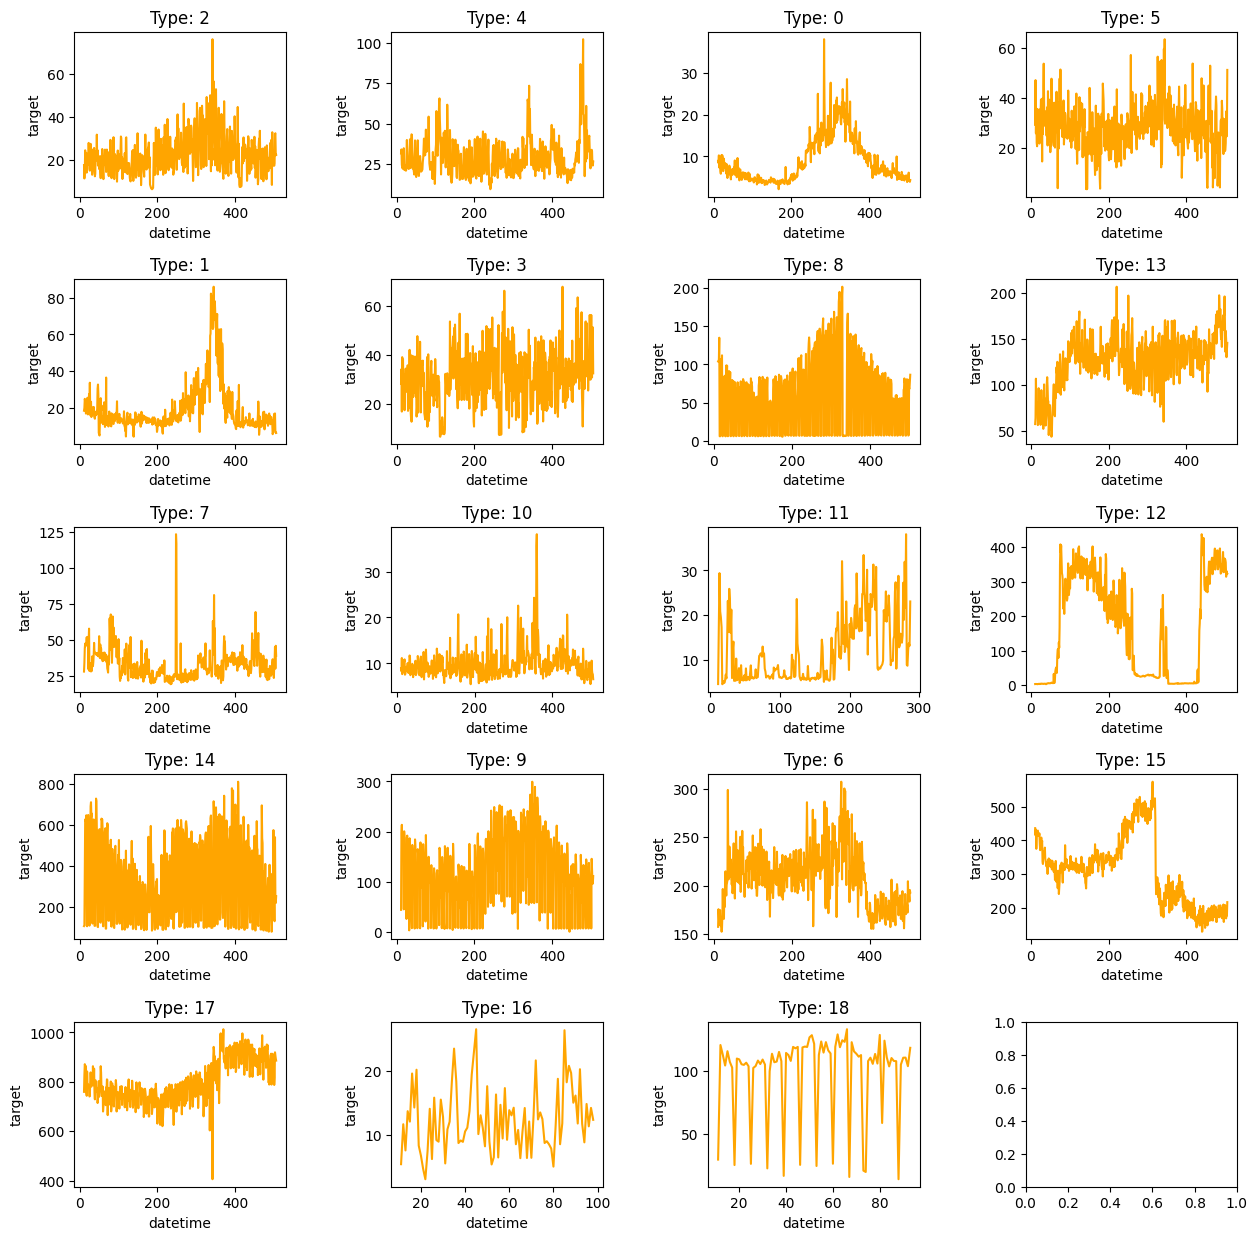

In [8]:
# we need subplots of one example's target line each type.

# 获取所有id和type
unique_idtypes = train_df.loc[:, ['id', 'type']].drop_duplicates(subset=['id']).reset_index(drop=True)
types = unique_idtypes['type'].drop_duplicates().tolist()

# 创建子图
n_types = len(types)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 15))
figs = axes.flatten()

for i, type_ in enumerate(types):
    ids = unique_idtypes[unique_idtypes['type'] == type_]
    random_id = ids.sample(1)['id'].values[0]
    tmp = train_df[train_df['id'] == random_id].sort_values(by='dt').reset_index(drop=True)
    figs[i].plot(tmp['dt'], tmp['target'], color='orange')
    figs[i].set_xlabel('datetime')
    figs[i].set_ylabel('target')
    figs[i].set_title(f'Type: {type_}')

# 调整子图之间的间距
plt.subplots_adjust(hspace=0.5, wspace=0.5)
# plt.tight_layout()
plt.show()

In [9]:
# 合并训练数据和测试数据，并进行排序
data = pd.concat([test_df, train_df], axis=0, ignore_index=True)
data = data.sort_values(['id','dt'], ascending=False).reset_index(drop=True)

# 历史平移
for i in range(10,30):
    data[f'last{i}_target'] = data.groupby(['id'])['target'].shift(i)
data
    
# 窗口统计
data[f'win3_mean_target'] = (data['last10_target'] + data['last11_target'] + data['last12_target']) / 3

# 进行数据切分
train = data[data.target.notnull()].reset_index(drop=True)
test = data[data.target.isnull()].reset_index(drop=True)

# # 确定输入特征
train_cols = [f for f in data.columns if f not in ['id','target']]
# train_cols

In [10]:
!pip install lightgbm

Looking in indexes: https://mirror.baidu.com/pypi/simple/, https://mirrors.aliyun.com/pypi/simple/


In [12]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error
import tqdm
import sys
import os
import gc
import argparse
import warnings
warnings.filterwarnings('ignore')


def time_model(lgb, train_df, test_df, cols):
 

    # 训练集和验证集切分
    trn_x, trn_y = train_df[train_df.dt>=31][cols], train_df[train_df.dt>=31]['target']
    val_x, val_y = train_df[train_df.dt<=30][cols], train_df[train_df.dt<=30]['target']
    # 构建模型输入数据
    train_matrix = lgb.Dataset(trn_x, label=trn_y)
    valid_matrix = lgb.Dataset(val_x, label=val_y)
    # lightgbm参数
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'mse',
        'min_child_weight': 5,
        'num_leaves': 2 ** 5,
        'lambda_l2': 10,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 4,
        'learning_rate': 0.025,
        'seed': 2024,
        'nthread' : 16,
        'verbose' : -1,
        'early_stopping_round' : 500
        # 'verbose_eval' : 500,
    }

    # 训练模型
    model = lgb.train(lgb_params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], 
                      categorical_feature=[], callbacks=[print_evaluation(period=500)])
    
    # 打印评估回调函数
    def print_evaluation(period=1):
        def callback(env):
            if (env.iteration + 1) % period == 0:
                print(f'Iteration {env.iteration + 1}, evaluation result: {env.evaluation_result_list}')
        return callback

    # 验证集和测试集结果预测
    val_pred = model.predict(val_x, num_iteration=model.best_iteration)
    test_pred = model.predict(test_df[cols], num_iteration=model.best_iteration)
       
    # 离线分数评估
    score = mean_squared_error(val_pred, val_y)
    print(score)
    
    return val_pred, test_pred
    
lgb_oof, lgb_test = time_model(lgb, train, test, train_cols)

# 保存结果文件到本地
test['target'] = lgb_test
test[['id','dt','target']].to_csv('submit.csv', index=None)

Iteration 500, evaluation result: [('training', 'l2', 192.34290910999715, False), ('valid_1', 'l2', 189.92740126346237, False)]
Iteration 1000, evaluation result: [('training', 'l2', 181.36818819995142, False), ('valid_1', 'l2', 185.3841855788365, False)]
Iteration 1500, evaluation result: [('training', 'l2', 175.12588271488517, False), ('valid_1', 'l2', 184.22496899410484, False)]
Iteration 2000, evaluation result: [('training', 'l2', 170.5459611881833, False), ('valid_1', 'l2', 184.02657881024567, False)]
183.6860000177447


In [9]:
# 合并训练数据和测试数据
data = pd.concat([train, test], axis=0).reset_index(drop=True)
data = data.sort_values(['id','dt'], ascending=False).reset_index(drop=True)

# 历史平移
for i in range(10,36):
    data[f'target_shift{i}'] = data.groupby('id')['target'].shift(i)

# 历史平移 + 差分特征
for i in range(1,4):
    data[f'target_shift10_diff{i}'] = data.groupby('id')['target_shift10'].diff(i)
    
# 窗口统计
for win in [15,30,50,70]:
    data[f'target_win{win}_mean'] = data.groupby('id')['target'].rolling(window=win, min_periods=3, closed='left').mean().values
    data[f'target_win{win}_max'] = data.groupby('id')['target'].rolling(window=win, min_periods=3, closed='left').max().values
    data[f'target_win{win}_min'] = data.groupby('id')['target'].rolling(window=win, min_periods=3, closed='left').min().values
    data[f'target_win{win}_std'] = data.groupby('id')['target'].rolling(window=win, min_periods=3, closed='left').std().values

# 历史平移 + 窗口统计
for win in [7,14,28,35,50,70]:
    data[f'target_shift10_win{win}_mean'] = data.groupby('id')['target_shift10'].rolling(window=win, min_periods=3, closed='left').mean().values
    data[f'target_shift10_win{win}_max'] = data.groupby('id')['target_shift10'].rolling(window=win, min_periods=3, closed='left').max().values
    data[f'target_shift10_win{win}_min'] = data.groupby('id')['target_shift10'].rolling(window=win, min_periods=3, closed='left').min().values
    data[f'target_shift10_win{win}_sum'] = data.groupby('id')['target_shift10'].rolling(window=win, min_periods=3, closed='left').sum().values
    data[f'target_shift710win{win}_std'] = data.groupby('id')['target_shift10'].rolling(window=win, min_periods=3, closed='left').std().values

: 

: 

In [6]:
!pip install keras
!pip install tensorflow

Cannot run install tensorflow because of system compatibility. AI Studio prepared an entire environment based on PaddlePaddle already. Please use PaddlePaddle to build your own model or application.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.optimizers import Adam


# 数据预处理
def preprocess_data(df, look_back=100):
    # 将数据按照id进行分组
    grouped = df.groupby('id')
    datasets = {}
    for id, group in grouped:
        datasets[id] = group.values
        
    # 准备训练数据集
    X, Y = [], []
    for id, data in datasets.items():
        for i in range(10, 15): # 每个id构建5个序列
            a = data[i:(i + look_back), 3]
            a = np.append(a, np.array([0]*(100-len(a))))
            X.append(a[::-1])
            Y.append(data[i-10:i, 3][::-1])
    
    # 准备测试数据集
    OOT = []
    for id, data in datasets.items():
        a = data[:100, 3]
        a = np.append(a, np.array([0]*(100-len(a))))
        OOT.append(a[::-1])
    
    return np.array(X, dtype=np.float64), np.array(Y, dtype=np.float64), np.array(OOT, dtype=np.float64)

# 定义模型
def build_model(look_back, n_features, n_output):
    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, n_features)))
    model.add(RepeatVector(n_output))
    model.add(LSTM(50, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mean_squared_error', optimizer=Adam(0.001))
    return model

# 构建和训练模型
look_back = 100  # 序列长度
n_features = 1  # 假设每个时间点只有一个特征
n_output = 10  # 预测未来10个时间单位的值

# 预处理数据
X, Y, OOT = preprocess_data(train, look_back=look_back)

# 构建模型
model = build_model(look_back, n_features, n_output)

# 训练模型
model.fit(X, Y, epochs=10, batch_size=64, verbose=1)

# 进行预测
predicted_values = model.predict(OOT)

In [32]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


def preprocess_data(df, look_back=100):
    # 将数据按照id进行分组
    grouped = df.groupby('id')
    datasets = {}
    for id, group in grouped:
        datasets[id] = group.values
        
    # 准备训练数据集
    X, Y = [], []
    for id, data in datasets.items():
        for i in range(10, 15): # 每个id构建5个序列
            a = data[i:(i + look_back), 3]
            a = np.append(a, np.array([0]*(100-len(a))))
            X.append(a[::-1])
            Y.append(data[i-10:i, 3][::-1])
    
    # 准备测试数据集
    OOT = []
    for id, data in datasets.items():
        a = data[:100, 3]
        a = np.append(a, np.array([0]*(100-len(a))))
        OOT.append(a[::-1])
    
    return np.array(X, dtype=np.float64), np.array(Y, dtype=np.float64), np.array(OOT, dtype=np.float64)

look_back = 100
n_features = 1
n_output = 10

X, Y, OOT = preprocess_data(train, look_back=look_back)

X.shape, Y.shape, OOT.shape

((29160, 100), (29160, 10), (5832, 100))

In [35]:
# 转换形状以适应PaddlePaddle
X = X.reshape((X.shape[0], X.shape[1], 1)).astype(np.float32)
Y = Y.reshape((Y.shape[0], Y.shape[1], 1)).astype(np.float32)
OOT = OOT.reshape((OOT.shape[0], OOT.shape[1], 1)).astype(np.float32)
X.shape, Y.shape, OOT.shape

((29160, 100, 1), (29160, 10, 1), (5832, 100, 1))

In [42]:
import paddle
import paddle.nn as nn
import paddle.optimizer as optim

class LSTMModel(nn.Layer):
    def __init__(self, look_back, n_features, n_output):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=50, num_layers=1)
        self.repeat_vector = paddle.nn.Linear(50, n_output * 50)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, num_layers=1)
        self.dense = nn.Linear(in_features=50, out_features=1)
        self.n_output = n_output

    def forward(self, x):
        x, _ = self.lstm1(x)  # x shape: [batch_size, look_back, 50]
        x = x[:, -1, :]  # Take the last output of the LSTM
        x = self.repeat_vector(x)  # x shape: [batch_size, n_output * 50]
        x = paddle.reshape(x, [-1, self.n_output, 50])  # Reshape to [batch_size, n_output, 50]
        x, _ = self.lstm2(x)  # x shape: [batch_size, n_output, 50]
        x = self.dense(x)  # x shape: [batch_size, n_output, 1]
        return x

look_back = 100
n_features = 1
n_output = 10

model = LSTMModel(look_back, n_features, n_output)
criterion = nn.MSELoss()
optimizer = optim.Adam(parameters=model.parameters(), learning_rate=0.001)


In [43]:
def train_model(model, criterion, optimizer, X, Y, epochs=10, batch_size=64):
    dataset = paddle.io.TensorDataset([X, Y])
    data_loader = paddle.io.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for batch_id, (batch_x, batch_y) in enumerate(data_loader()):
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            optimizer.clear_grad()
            if batch_id % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Batch [{batch_id}], Loss: {loss.numpy()}')

train_model(model, criterion, optimizer, X, Y, epochs=10, batch_size=64)


Epoch [1/10], Batch [0], Loss: 3803.788330078125
Epoch [1/10], Batch [10], Loss: 2402.94775390625
Epoch [1/10], Batch [20], Loss: 1553.6431884765625
Epoch [1/10], Batch [30], Loss: 3721.116455078125
Epoch [1/10], Batch [40], Loss: 1990.071044921875
Epoch [1/10], Batch [50], Loss: 3183.145751953125
Epoch [1/10], Batch [60], Loss: 1737.2835693359375
Epoch [1/10], Batch [70], Loss: 2972.779296875
Epoch [1/10], Batch [80], Loss: 3994.09814453125
Epoch [1/10], Batch [90], Loss: 4026.89111328125
Epoch [1/10], Batch [100], Loss: 4115.95703125
Epoch [1/10], Batch [110], Loss: 4525.61865234375
Epoch [1/10], Batch [120], Loss: 2311.072998046875
Epoch [1/10], Batch [130], Loss: 1567.0550537109375
Epoch [1/10], Batch [140], Loss: 4340.6650390625
Epoch [1/10], Batch [150], Loss: 2865.36181640625
Epoch [1/10], Batch [160], Loss: 4891.08056640625
Epoch [1/10], Batch [170], Loss: 2728.030029296875
Epoch [1/10], Batch [180], Loss: 2775.83935546875
Epoch [1/10], Batch [190], Loss: 1647.946533203125
Epoc

In [46]:
def predict(model, OOT):
    model.eval()
    with paddle.no_grad():
        predictions = model(paddle.to_tensor(OOT))
    return predictions.numpy()

predicted_values = predict(model, OOT)


(5832, 10, 1)

In [50]:
test['target'] = predicted_values.reshape(58320, -1)
test[['id','dt','target']].to_csv('submit.csv', index=None)

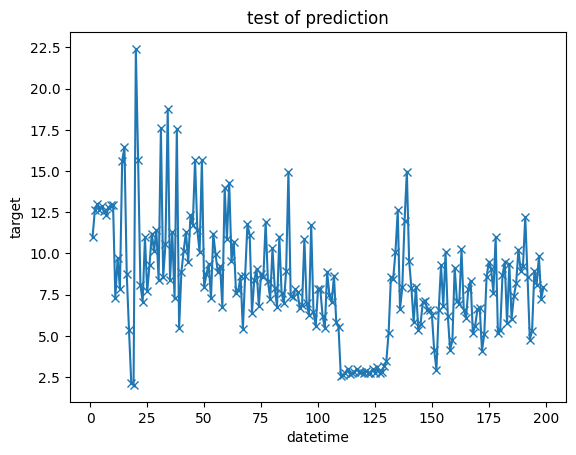

In [59]:
# 合并训练数据和测试数据，并进行排序
data = pd.concat([pd.read_csv('submit.csv', header=0), train], axis=0, ignore_index=True)
data = data.sort_values(['id','dt'], ascending=False).reset_index(drop=True)
data.head()
# data['id'].drop_duplicates()
subset = data[(data['id'] == 'ffe1c50bbb') & (data['dt'] < 200)]
plt.plot(subset['dt'], subset['target'], linestyle='-', marker='x')
plt.xlabel('datetime')
plt.ylabel('target')
plt.title('test of prediction')
plt.show()